In [2]:
import skimage as sk
import matplotlib.pyplot as plt
from dottamine import dotim
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, rotate
import tifffile as tiff
import multiprocessing
from multiprocessing import Pool
import common_functions
import os
import warnings
from scipy.ndimage import zoom
from joblib import Parallel, delayed

In [2]:
def normalize_image(im, mult_factor = 1):
    '''
    Normalize image (any Dimensions) function.
    '''
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

In [3]:

folder_and_dome = str('./../../../../Desktop/dome70_fallinglineMove/70_denoised_tp4')
image_path = folder_and_dome+'_apical_dots_total_1.tif'

image = sk.io.imread(image_path)



# Now we should get the propper cleaned dots

In [16]:
from scipy.ndimage import rotate

def rotate_x(array, angle):
    """
    Rotate a 3D array around the X-axis by a given angle in degrees.
    
    Parameters:
        array (ndarray): Input 3D array.
        angle (float): Angle of rotation in degrees.
        
    Returns:
        ndarray: Rotated 3D array.
    """
    # Transpose the array so that the X-axis becomes the Z-axis
    transposed_array = np.transpose(array, (1, 0, 2))
    # Rotate the transposed array around the Z-axis by the desired angle
    rotated_array = rotate(transposed_array, angle, axes=(0,1), reshape=False)
    # Transpose the rotated array back to the original orientation
    rotated_array = np.transpose(rotated_array, (1, 0, 2))
    return rotated_array

In [23]:
max_intensity_indices_0 = np.argmax(image, axis=0)

rot_10 = rotate_x(image,10)

max_intensity_indices_0_rot = np.argmax(rot_10, axis=0)


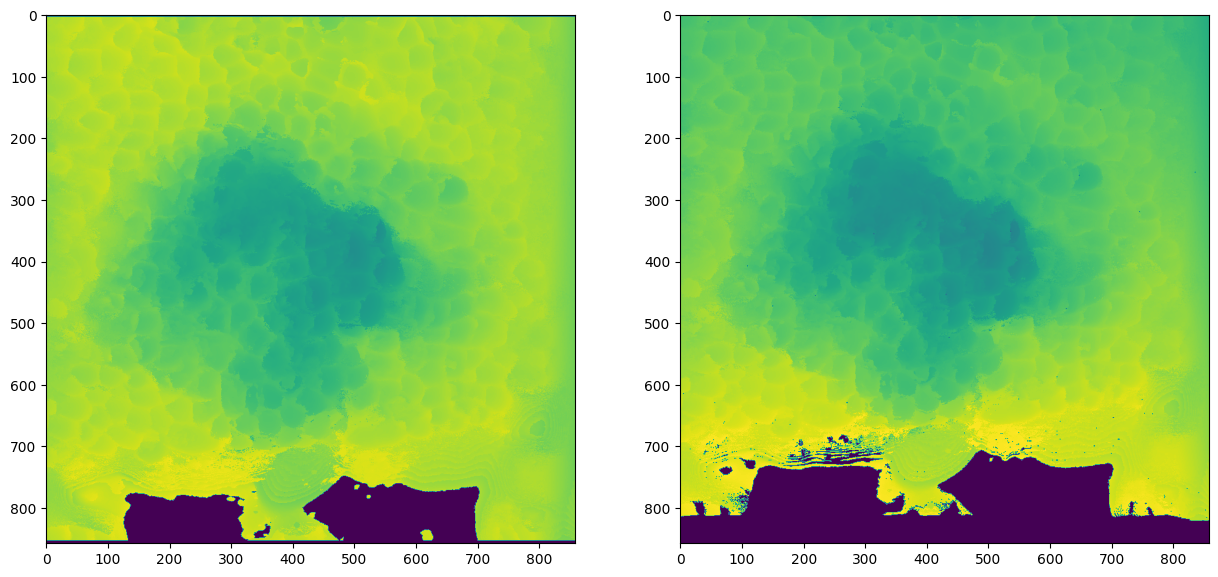

In [24]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(max_intensity_indices_0)
plt.subplot(122)
plt.imshow(max_intensity_indices_0_rot)

In [22]:
def rotate_3d_array(data, angle, axes=(0, 1)):
    """
    Rotate a 3D numpy array by a given angle around specified axes.
    
    Parameters:
    - data: The 3D numpy array to be rotated.
    - angle: The angle of rotation in degrees.
    - axes: The axes around which to rotate. Default is (0, 1).
    
    Returns:
    - The rotated 3D numpy array.
    """
    # Ensure the angle is in radians
    angle_rad = np.deg2rad(angle)
    
    # Create a grid of indices
    shape = data.shape
    d1, d2, d3 = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]
    
    # Rotate the indices
    d1r = rotate(d1, angle=angle_rad, axes=axes)
    d2r = rotate(d2, angle=angle_rad, axes=axes)
    d3r = rotate(d3, angle=angle_rad, axes=axes)
    
    # Clip the rotated indices to ensure they stay within the original array bounds
    d1r = np.clip(d1r, 0, shape[0])
    d2r = np.clip(d2r, 0, shape[1])
    d3r = np.clip(d3r, 0, shape[2])
    
    # Return the rotated array
    return data[d1r.astype(int), d2r.astype(int), d3r.astype(int)]

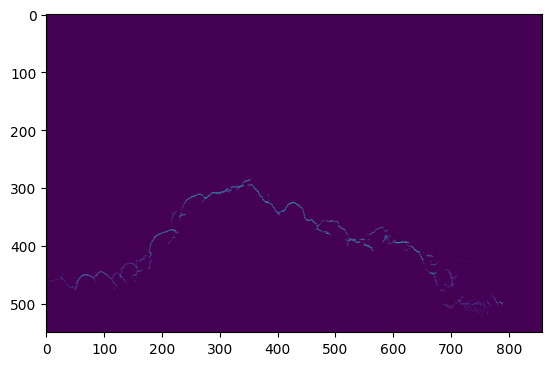

In [5]:
image_r = common_functions.get_image_r(image=image)
plt.imshow(image_r[300])

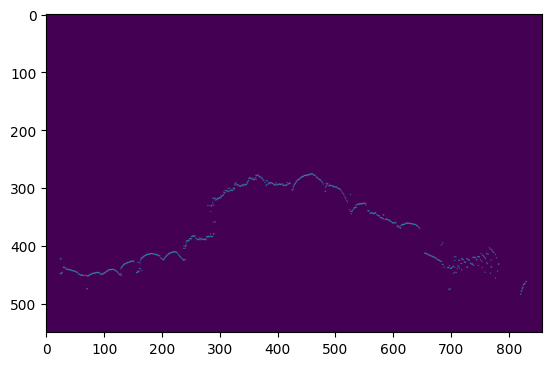

In [6]:
def top_dots_2D(dots, angle=0):

    rot_dots = rotate(dots, angle, reshape=False)

    top_dots = np.zeros(shape=(dots.shape))

    top_dots[np.argmax(rot_dots, axis=0), list(range(top_dots.shape[1]))] = 1
    
    cell_top_mask_rot = rotate(top_dots, -angle, reshape=False)

    cell_top_mask_rot[cell_top_mask_rot < 0] = 0
    horizontal_cut = 4
    cell_top_mask_rot[:, :horizontal_cut] = 0
    cell_top_mask_rot[:, -horizontal_cut:] = 0
    return np.array(cell_top_mask_rot)

plt.imshow(top_dots_2D(image_r[440], angle=-10))

In [7]:
a = Parallel(n_jobs=-1)(delayed(top_dots_2D)(i, 10) for i in image_r)
a2 = Parallel(n_jobs=-1)(delayed(top_dots_2D)(i, -10) for i in image_r)

In [8]:
a = np.transpose(a, axes=(1,2,0)) 
a2 = np.transpose(a2, axes=(1,2,0)) 

In [9]:
b = Parallel(n_jobs=-1)(delayed(top_dots_2D)(i, 10) for i in np.transpose(image_r, axes=(2,1,0)))
b2 = Parallel(n_jobs=-1)(delayed(top_dots_2D)(i, -10) for i in np.transpose(image_r, axes=(2,1,0)))

In [10]:
b = np.transpose(b2, axes=(1,2,0))
b2 = np.transpose(b2, axes=(1,2,0))

b = np.transpose(b, axes=(0,2,1))
b2 = np.transpose(b2, axes=(0,2,1))

In [11]:
c = Parallel(n_jobs=-1)(delayed(top_dots_2D)(i, 0) for i in image_r)

In [12]:
c = np.transpose(c, axes=(1,2,0)) 

In [13]:
d = a+a2+b+b2+c

In [14]:
tiff.imwrite('./../../../../Desktop/dome70_fallinglineMove/70_denoised_tp4_dots_different_top.tif', common_functions.normalize_image(d, 255).astype(np.uint16))

# Once we have the clean dots, we can get the gaussian shape

In [7]:
folder_and_dome = str('./../../../../Desktop/dome70_tp4_fallingline/70_denoised_tp4')
image_path = folder_and_dome+'_apical_dots_total_1.tif'

image = sk.io.imread(image_path)
max_intensity_indices_0 = np.argmax(image, axis=0)

from_top = np.zeros(shape=(image.shape))



In [4]:
# from_top[max_intensity_indices_0, np.indices(max_intensity_indices_0.shape)[0], np.indices(max_intensity_indices_0.shape)[1]] = 1

# tiff.imwrite('./../../../../Desktop/dome70_fallinglineMove/70_denoised_tp4_dots_different_top.tif', common_functions.normalize_image(from_top, 255).astype(np.uint16))

: 

In [12]:
new_image = common_functions.get_3D_gaussian(image, sigma_single=10)
print(image.shape)
print(new_image.shape)

(550, 858, 858)
(550, 858, 858)


In [13]:
new_image = common_functions.get_image_r(new_image)
## Find the top line of the mask
first_nonzero_indices = np.argmax(new_image != 0, axis=1)
top_mask = np.zeros_like(new_image) # Line from top
top_mask[np.arange(new_image.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(new_image.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

## Find the left line of the mask
first_left_nonzero_indices = np.argmax(new_image != 0, axis=2)
left_mask = np.zeros_like(new_image) # Line from left
left_mask[np.arange(new_image.shape[0])[:, None, None], np.arange(new_image.shape[1]), first_left_nonzero_indices[None, :, None]] = 1 # Top mask is a 3D array that contains the left line of the actual mask

## Find the right line of the mask
last_right_nonzero_indices = new_image.shape[2] - np.argmax(new_image[:, :, ::-1] != 0, axis=2) - 1
right_mask = np.zeros_like(new_image) # Line from right
right_mask[np.arange(new_image.shape[0])[:, None, None], np.arange(new_image.shape[1]), last_right_nonzero_indices[None, :, None]] = 1 # Right mask is a 3D array that contains the right line of the actual mask

sum_mask = top_mask+left_mask+right_mask # Sum of lines from top
# Make the first and last for each axis 0.
sum_mask[0, :, :] = 0
sum_mask[-1, :, :] = 0
sum_mask[:, 0, :] = 0
sum_mask[:, -1, :] = 0
sum_mask[:, :, 0] = 0
sum_mask[:, :, -1] = 0

sum_mask = np.transpose(sum_mask, axes=(1,2,0)) # Sum viewed from top

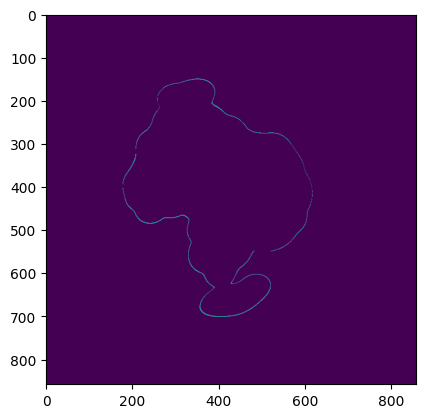

In [14]:
plt.imshow(sum_mask[300])

In [15]:
tiff.imwrite('./../../../../Desktop/dome70_tp4_fallingline/70_denoised_tp4_gauss_top_2.tif', common_functions.normalize_image(sum_mask, 255).astype(np.uint16))